In [5]:
!pip install swifter

  Using cached swifter-1.0.7.tar.gz (633 kB)
  Using cached modin-0.8.2-py3-none-manylinux1_x86_64.whl (533 kB)
     |████████████████████████████████| 17.2 MB 4.4 MB/s eta 0:00:01


     |████████████████████████████████| 114 kB 44.3 MB/s eta 0:00:01


  Created wheel for swifter: filename=swifter-1.0.7-py3-none-any.whl size=13977 sha256=5984d820571c466d0f19e6560f4786b1ab44230fff64338fe7670569ff124ea0
  Stored in directory: /root/.cache/pip/wheels/49/44/5b/2c3fcb044734cb9969adbeeab8de419e571fb3d9d0b9f62dae
Successfully built swifter
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 0.16.0
    Uninstalling pyarrow-0.16.0:
      Successfully uninstalled pyarrow-0.16.0
  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.14.0
    Uninstalling google-auth-1.14.0:
      Successfully uninstalled google-auth-1.14.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kubernetes 10.1.0 requires pyyaml~=3.12, but you'll have pyyaml 5.3.1 which is incomp

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import urllib
import cv2


#Plots
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
#Nicer style
style.use('seaborn') 

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 




#Progress bars
from tqdm import tqdm
tqdm.pandas()

#Paralelize pandas apply on multiple cores
import swifter

import random

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
data = pd.read_csv("/kaggle/input/fake-news/all_data (1).csv")

In [8]:
data.head()

,Unnamed: 0,Unnamed: 0.1,author,comments,country,crawled,domain_rank,id,language,likes,...,fear,joy,sadness,surprise,trust,negative,positive,first_all,second_all,third_all
0,1,NaN,JEREMY W. PETERS,0.0,US,2017-03-14 08:25:04,0,3.0,english,0.0,...,6,20,5,14,30,14,52,409,150,45
1,2,NaN,STEVE EDER,0.0,US,2017-03-14 08:25:36,0,4.0,english,0.0,...,4,4,4,5,9,8,15,145,38,28
2,3,NaN,MAGGIE HABERMAN ASHLEY PARKER,0.0,US,2017-03-14 08:25:36,0,5.0,english,0.0,...,8,15,8,6,26,15,34,440,168,68
3,4,NaN,NELSON D. SCHWARTZ SUI-LEE WEE,0.0,US,2017-03-14 08:25:36,0,6.0,english,0.0,...,10,10,10,6,32,24,43,592,136,71
4,5,NaN,MAGGIE HABERMAN,0.0,US,2017-03-14 08:25:37,0,7.0,english,0.0,...,3,6,2,4,14,4,25,223,82,28


In [9]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'comments', 'country',
       'crawled', 'domain_rank', 'id', 'language', 'likes', 'main_img_url',
       'ord_in_thread', 'participants_count', 'published', 'replies_count',
       'shares', 'site_url', 'spam_score', 'text', 'thread_title', 'title',
       'type', 'uuid', 'caps_title', 'caps_thread', 'caps_text', 'title_len',
       'thread_len', 'text_len', 'excl_title', 'excl_thread', 'excl_text',
       'first_title', 'first_thread', 'first_text', 'second_title',
       'second_thread', 'second_text', 'third_title', 'third_thread',
       'third_text', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'sadness', 'surprise', 'trust', 'negative', 'positive', 'first_all',
       'second_all', 'third_all'],
      dtype='object')

Selecting only those columns that we require

In [10]:
data = data[['main_img_url', 'text', 'title', 'type']]

In [11]:
data

,main_img_url,text,title,type
0,https://static01.nyt.com/images/2016/11/23/us/...,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",real
1,https://static01.nyt.com/images/2016/10/18/us/...,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,real
2,https://static01.nyt.com/images/2016/11/12/us/...,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",real
3,https://static01.nyt.com/images/2016/10/21/bus...,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,real
4,https://static01.nyt.com/images/2016/11/21/us/...,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,real
...,...,...,...,...
20010,https://t4.rbxcdn.com/c5695e5f087535e2066dc473...,Most conservatives who oppose marriage equalit...,Alabama Lawmaker: Same-Sex Couples Don<U+2019>...,real
20011,https://t4.rbxcdn.com/c5695e5f087535e2066dc473...,The freshman senator from Georgia quoted scrip...,GOP Senator David Perdue Jokes About Praying f...,real
20012,https://t4.rbxcdn.com/c5695e5f087535e2066dc473...,The State Department told the Republican Natio...,State Department says it can't find emails fro...,real
20013,https://t4.rbxcdn.com/c5695e5f087535e2066dc473...,"ADDIS ABABA, Ethiopia <U+2014>President Obama ...","In Ethiopia, Obama seeks progress on peace, se...",real


In [12]:
print(data.isna().sum())
data.isnull().sum()

main_img_url    0
text            0
title           0
type            0
dtype: int64


main_img_url    0
text            0
title           0
type            0
dtype: int64

Visualize variation in data

In [13]:
# from PIL import Image
# import requests
# from io import BytesIO
# images = []
# for url in data['main_img_url']:
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
#     images.append(img)

In [14]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

In [15]:
corpus_text = [clean_text_array(i) for i in data[data['type'] == 'fake']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in data[data['type'] == 'real']['title'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)

In [16]:
most_common_truth

[('trump', 2805),
 ('wsj', 2132),
 ('politico', 1310),
 ('clinton', 1136),
 ('donald', 836),
 ('news', 549),
 ('hillary', 505),
 ('obama', 483),
 ('election', 388),
 ('gop', 360),
 ('new', 315),
 ('debate', 299),
 ('u', 274),
 ('political', 251),
 ('says', 238),
 ('campaign', 236),
 ('house', 226),
 ('american', 201),
 ('breaking', 199),
 ('republicans', 178)]

In [17]:
most_common_fake

[('trump', 1528),
 ('hillary', 1164),
 ('clinton', 1039),
 ('notitle', 591),
 ('election', 543),
 ('us', 502),
 ('new', 481),
 ('russia', 404),
 ('news', 400),
 ('war', 385),
 ('fbi', 383),
 ('comment', 379),
 ('america', 354),
 ('world', 328),
 ('obama', 316),
 ('donald', 276),
 ('now', 269),
 ('wikileaks', 219),
 ('breaking', 208),
 ('emails', 207)]

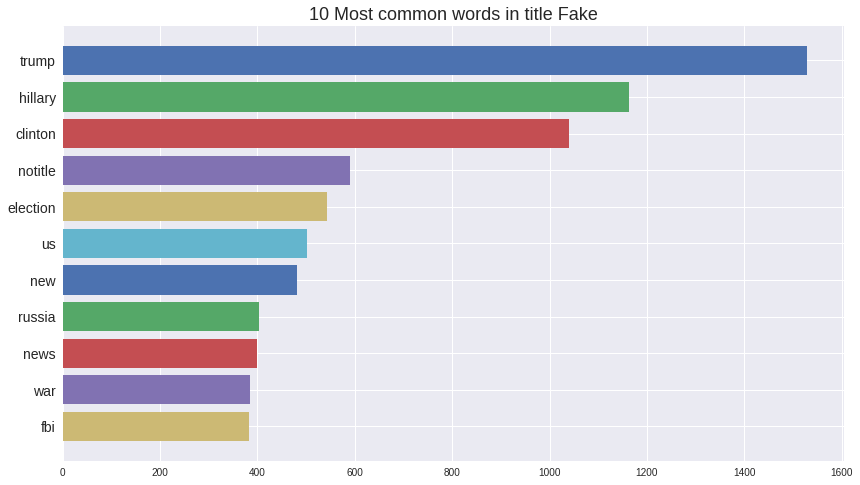

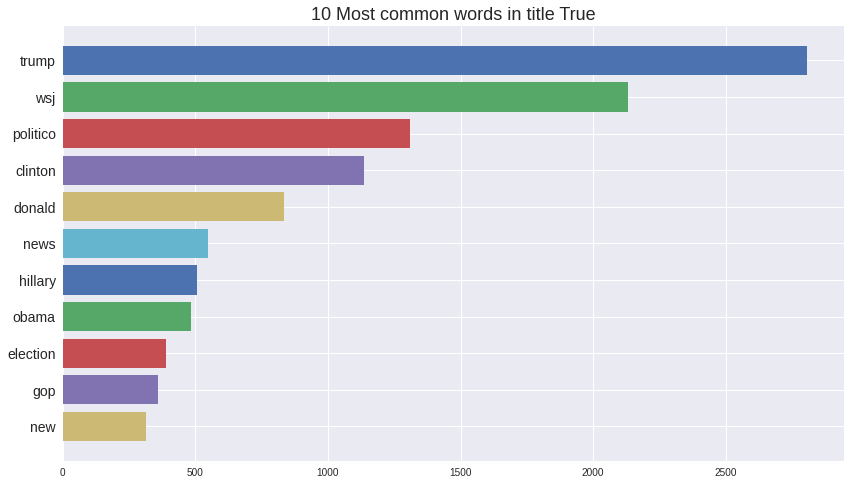

In [18]:

names = ["10 Most common words in title Fake", "10 Most common words in title True"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

In [19]:
corpus_text = [clean_text(i) for i in data[data['type'] == 'fake']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count
    

corpus_text = [clean_text(i) for i in data[data['type'] == 'real']['title'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

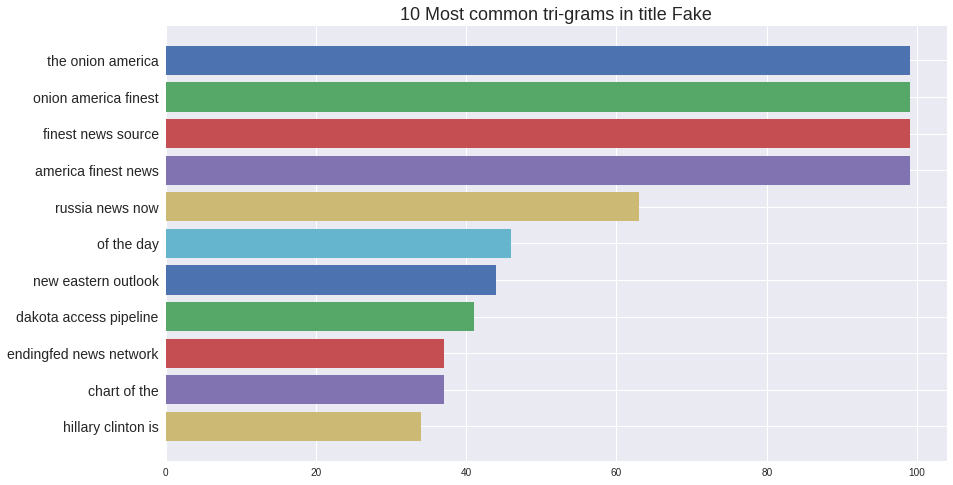

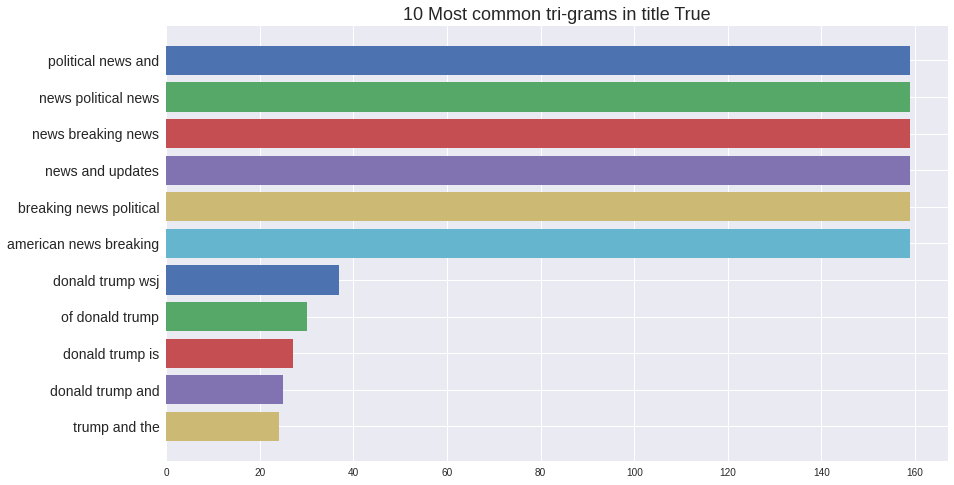

In [20]:
names = ["10 Most common tri-grams in title Fake", "10 Most common tri-grams in title True"]
variables = [ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

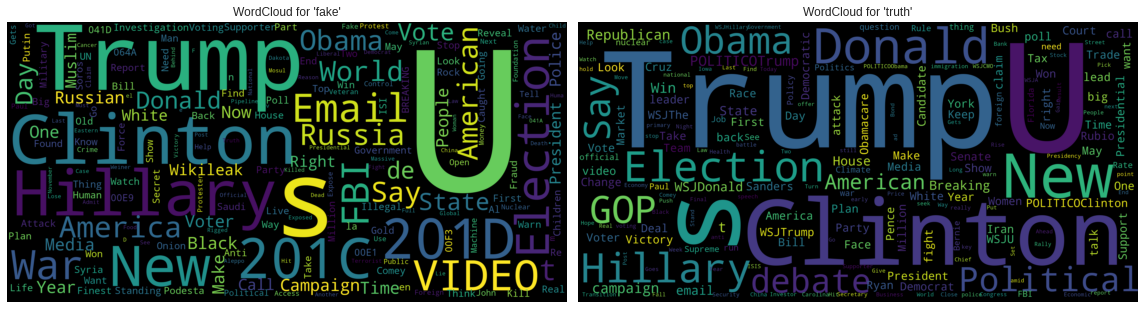

In [21]:
fig, ax = plt.subplots(1,2, figsize=(16,16))

corpus_text = ''.join(data[data['type'] == 'fake']['title'].tolist())
corpus_text = re.sub('(043)\w+|(044)\w+', '', corpus_text)  
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")

corpus_text = ''.join(data[data['type'] == 'real']['title'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'truth'")

plt.tight_layout()

In [22]:
stop_words = STOPWORDS.union(set(["will", "one", "new"]))

In [24]:
data['clean_content'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
data['clean_title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)

In [26]:
data.head(5)

,main_img_url,text,title,type,clean_content,clean_title
0,https://static01.nyt.com/images/2016/11/23/us/...,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",real,they stood in line at trump tower sometimes up...,at donald trump properties a showcase for a br...
1,https://static01.nyt.com/images/2016/10/18/us/...,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,real,donald j trump foundation informed attorney ge...,trump foundation tells new york it has stopped...
2,https://static01.nyt.com/images/2016/11/12/us/...,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",real,president donald j trump won the white house w...,donald trump prepares for white house move but...
3,https://static01.nyt.com/images/2016/10/21/bus...,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,real,an investment pitch for a new texas hotel is t...,luring chinese investors with trump name and l...
4,https://static01.nyt.com/images/2016/11/21/us/...,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,real,president donald j trump wife melania and thei...,melania and barron trump won immediately move ...


In [28]:
data['len_content'] = data.swifter.apply(lambda row: len(row['clean_content']), axis=1)


Text(0.5, 0.98, '')

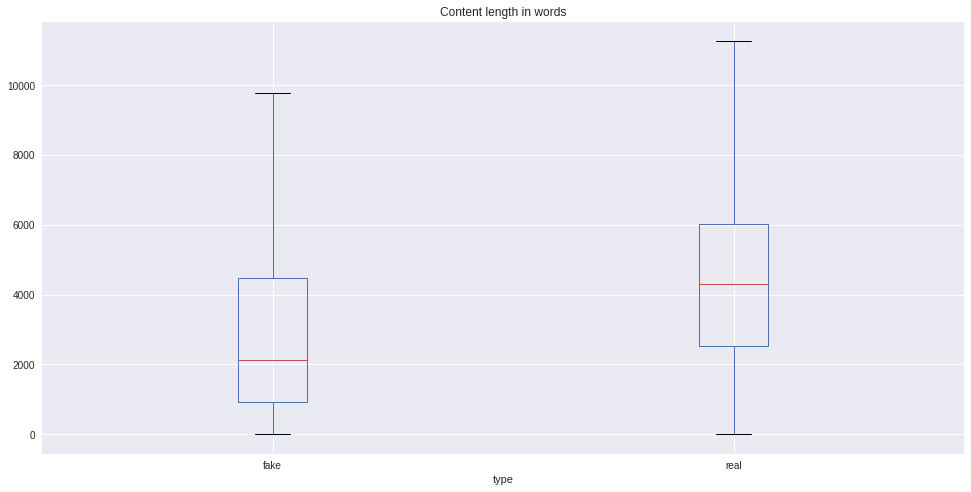

In [31]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Content length in words")
plt.suptitle("")

In [32]:
corpus_text = '. '.join([i for i in data[data['type'] == 'fake']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in data[data['type'] == 'real']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

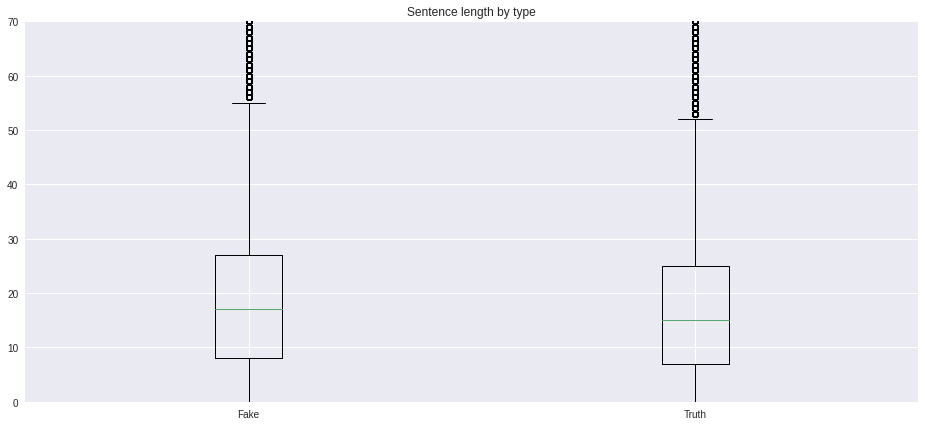

In [33]:
fig, ax = plt.subplots(1,1, figsize=(16,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth], 
            labels=['Fake', 'Truth'])
plt.show()

In [35]:
data['number_of_sentences'] = data.swifter.apply(lambda row: len(row['text'].split(". ")), axis=1)


Text(0.5, 0.98, '')

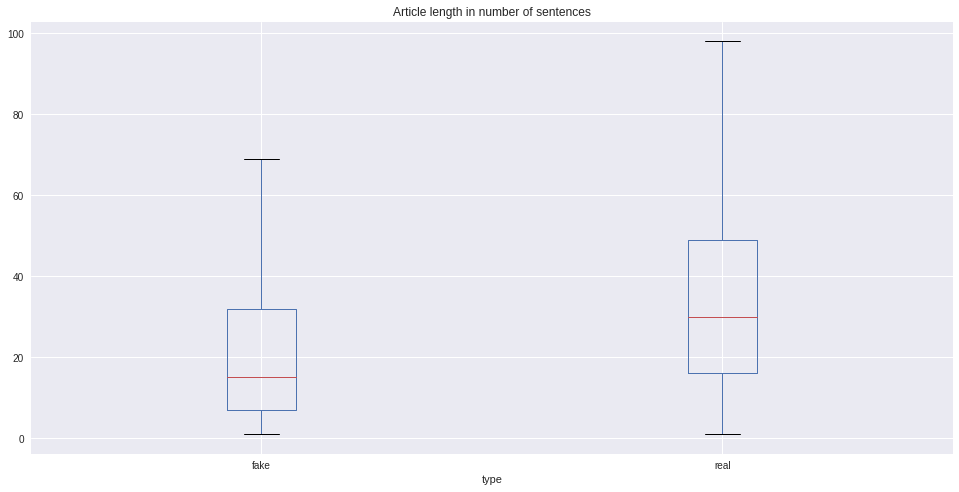

In [37]:

fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['number_of_sentences'], by='type', ax=ax, showfliers=False)
plt.title("Article length in number of sentences")
plt.suptitle("")

In [40]:
data['num_of_marks'] = data.text.str.count("!|\?")

Text(0.5, 0.98, '')

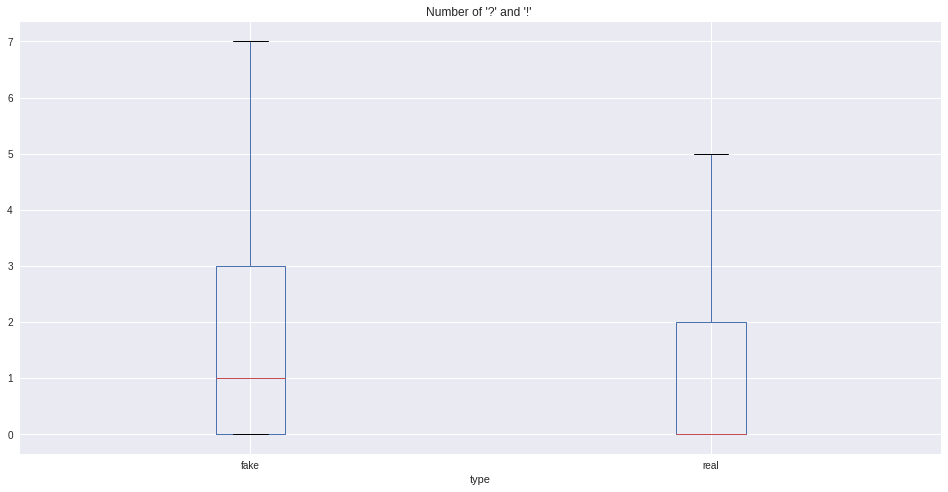

In [41]:

fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['num_of_marks'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [45]:
def count_person_forms(text, person):
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter

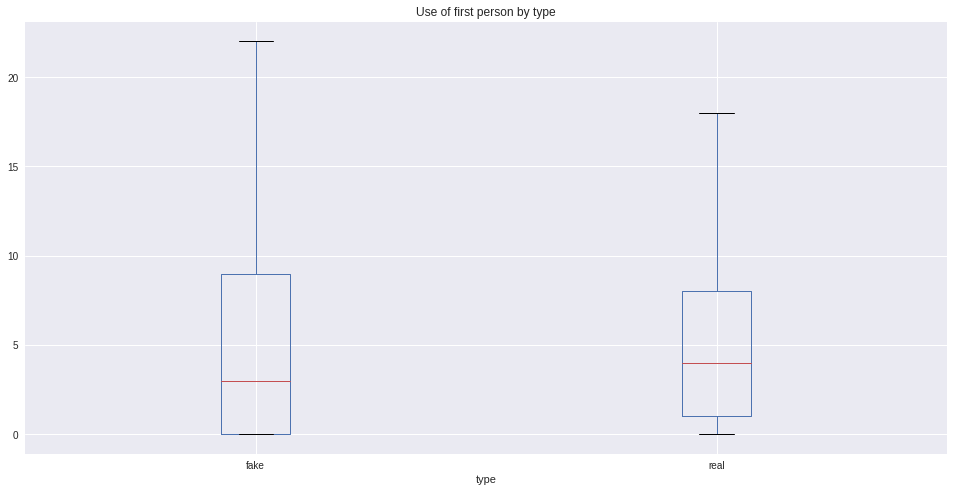

In [44]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

data['first_person'] = data.swifter.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of first person by type")
fig.suptitle("")
plt.show()

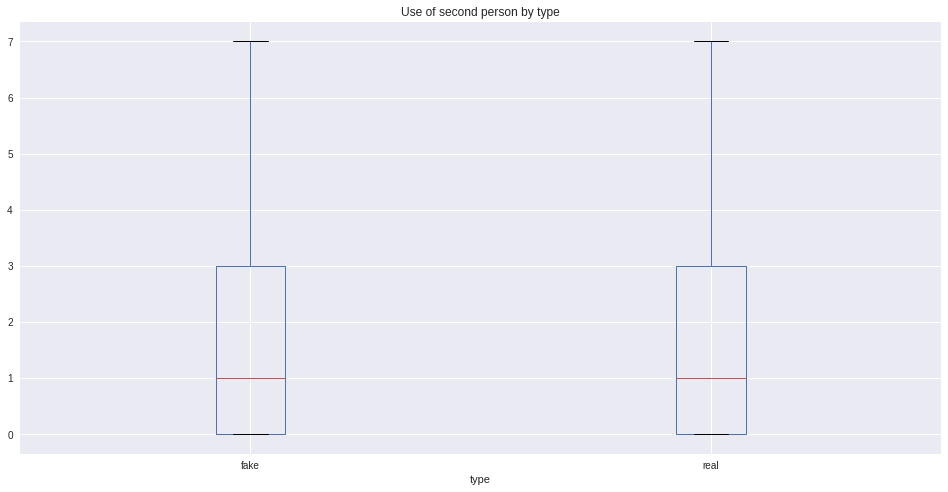

In [53]:
data['second_person'] = data.swifter.apply(lambda row: count_person_forms(row['text'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of second person by type")
fig.suptitle("")
plt.show()

In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [57]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [59]:
data['sentiment'] = data.swifter.apply(lambda r: classify_sentiment(r['text']), axis=1)


(pid=155) UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
(pid=157) UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
(pid=154) UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.


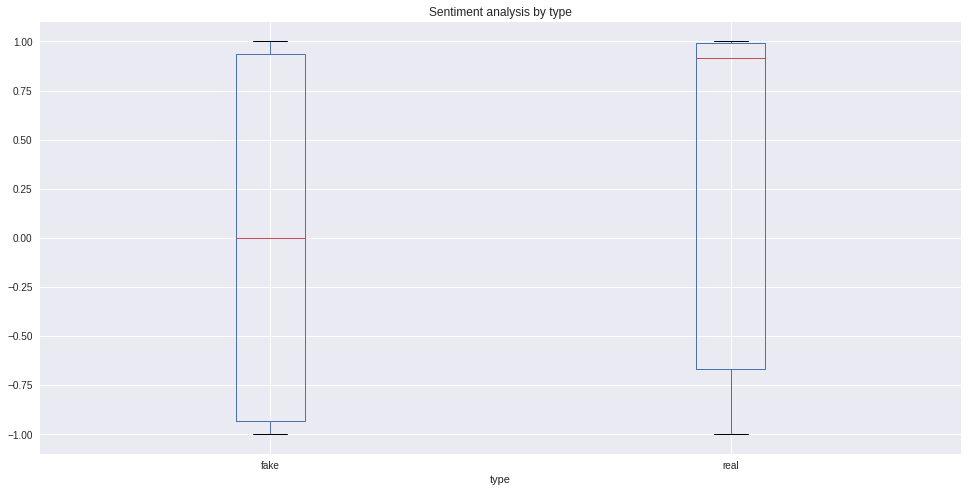

In [61]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
data.boxplot(column=['sentiment'], by='type', ax=ax, showfliers=False)
ax.set_title("Sentiment analysis by type")
fig.suptitle("")
plt.show()

In [62]:

def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [63]:
data['lexical_diver'] = data.swifter.apply(lambda r: lexical_diversity(r['text']), axis=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = data.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

In [55]:
data.head(5)

,main_img_url,text,title,type,clean_content,clean_title,len_content,number_of_sentences,num_of_marks,first_person,second_person
0,https://static01.nyt.com/images/2016/11/23/us/...,"They stood in line at Trump Tower, sometimes u...","At Donald Trump<U+2019>s Properties, a Showcas...",real,they stood in line at trump tower sometimes up...,at donald trump properties a showcase for a br...,5986,72,2,4,0
1,https://static01.nyt.com/images/2016/10/18/us/...,Donald J. Trump <U+2019>s foundation informed ...,Trump Foundation Tells New York It Has Stopped...,real,donald j trump foundation informed attorney ge...,trump foundation tells new york it has stopped...,2014,26,0,0,1
2,https://static01.nyt.com/images/2016/11/12/us/...,President-elect Donald J. Trump won the White ...,"Donald Trump Prepares for White House Move, bu...",real,president donald j trump won the white house w...,donald trump prepares for white house move but...,5839,57,2,2,2
3,https://static01.nyt.com/images/2016/10/21/bus...,An investment pitch for a new Texas hotel is t...,Luring Chinese Investors With Trump<U+2019>s N...,real,an investment pitch for a new texas hotel is t...,luring chinese investors with trump name and l...,7373,79,0,6,4
4,https://static01.nyt.com/images/2016/11/21/us/...,President-elect Donald J. Trump <U+2019>s wife...,Melania and Barron Trump Won<U+2019>t Immediat...,real,president donald j trump wife melania and thei...,melania and barron trump won immediately move ...,2822,32,0,0,0


In [ ]:
# from nltk.tokenize import word_tokenize, sent_tokenize
# words_count = []
# sents_count = []
# word_tokenized = []
# sent_tokenized = []
# for x in data['text']:
#     word_tokenized.append(word_tokenize(x))
#     sent_tokenized.append(sent_tokenize(x))

In [ ]:
# print((word_tokenized[0]))


In [ ]:
# for x in word_tokenized:
#     words_count.append(len(x))
# print(words_count[0])

In [ ]:
# for x in sent_tokenized:
#     sents_count.append(len(x))
# print(sents_count)

In [ ]:
# words_per_sent = []
# for i in range(len(words_count)):
#         if sents_count[i] == 0:
#             words_per_sent.append(words_count[i])
#             continue
#         words_per_sent.append(words_count[i] / sents_count[i])
# print(words_per_sent[0])

In [ ]:
# data['word_count'] = words_count
# data['words_per_sent'] = words_per_sent

In [ ]:
# excl_count = []
# fpp_count = []
# for x in data["text"]:
#     count = x.count("!")
#     excl_count.append(count)
#     fp_count = x.count("I ") + x.count("me ") + x.count("mine ") + x.count("myself") + x.count("Myself") + x.count("We ") + x.count("we ") + x.count("our ") + x.count("Our ")
#     fpp_count.append(fp_count)

In [ ]:
# data["excl_count"] = excl_count
# data["fpp_count"] = fpp_count

In [ ]:
# import seaborn as sns
# ax = sns.boxplot(x="type", y="word_count", data=data)
# ax.set_ylim(0,10000)
# start, end = ax.get_ylim()
# _ = ax.yaxis.set_ticks(np.arange(start, end, 500))

In [ ]:
# ax = sns.boxplot(x="type", y="words_per_sent", data=data)
# ax.set_ylim(0,200)
# start, end = ax.get_ylim()
# _ = ax.yaxis.set_ticks(np.arange(start, end, 50))

In [ ]:
# ax = sns.boxplot(x="type", y="excl_count", data=data)
# ax.set_ylim(0,50)
# start, end = ax.get_ylim()
# _ = ax.yaxis.set_ticks(np.arange(start, end, 10))

In [ ]:
# ax = sns.boxplot(x="type", y="fpp_count", data=data)
# ax.set_ylim(0,100)
# start, end = ax.get_ylim()
# _ = ax.yaxis.set_ticks(np.arange(start, end, 10))